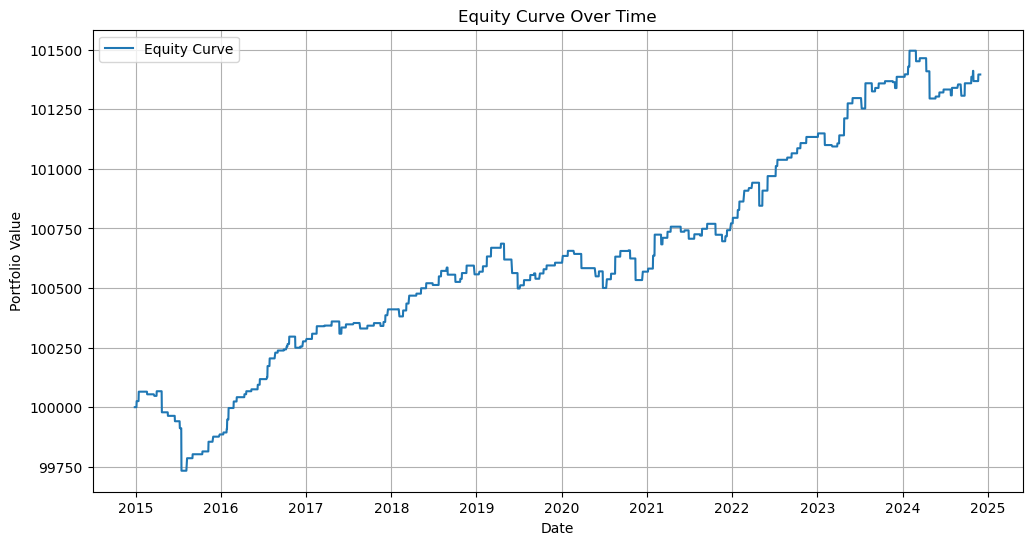

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm
import random

import os

def load_stock_files_from_directory(directory):
    """
    Dynamically load all stock files from a specified directory.
    Assumes each file is named with the stock ticker (e.g., AAPL.csv).
    """
    file_paths = {}
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            ticker = file.replace(".csv", "")
            file_paths[ticker] = os.path.join(directory, file)
    return file_paths


def load_stock_data(file_paths):
    """Load stock data from file paths."""
    stock_data = {ticker: pd.read_csv(path, index_col='Date', parse_dates=True) for ticker, path in file_paths.items()}
    return stock_data

def analyze_all_pairs(stock_data):
    """Analyze all pairs for cointegration and correlation."""
    results = []
    tickers = list(stock_data.keys())

    for ticker1, ticker2 in combinations(tickers, 2):
        try:
            stock1 = stock_data[ticker1]
            stock2 = stock_data[ticker2]
            
            # Align date ranges
            common_dates = stock1.index.intersection(stock2.index)
            stock1 = stock1.loc[common_dates]
            stock2 = stock2.loc[common_dates]
            
            # Cointegration test
            _, pvalue, _ = coint(stock1['Close'], stock2['Close'])
            correlation = stock1['Close'].corr(stock2['Close'])
            
            # Log spread and ADF test
            spread = np.log(stock1['Close']) - np.log(stock2['Close'])
            adf_pvalue = adfuller(spread)[1]
            
            results.append({
                'pair': f"{ticker1}-{ticker2}",
                'cointegration_pvalue': pvalue,
                'correlation': correlation,
                'adf_pvalue': adf_pvalue
            })
        except Exception as e:
            print(f"Error analyzing pair {ticker1}-{ticker2}: {e}")
    return pd.DataFrame(results)

def select_best_pair(results, cointegration_threshold=0.05, adf_threshold=0.05):
    print(results,"\n\n")
    """Select the best pair based on cointegration and stationarity."""
    suitable_pairs = results[
        (results['cointegration_pvalue'] < cointegration_threshold) & 
        (results['adf_pvalue'] < adf_threshold)
    ]
    if not suitable_pairs.empty:
        best_pair = suitable_pairs.sort_values('correlation', ascending=False).iloc[0]
        return best_pair['pair']
    else:
        return results.sort_values('correlation', ascending=False).iloc[0]['pair']

def calculate_kappa_and_half_life(stock1, stock2):
    """Calculate kappa and half-life of mean reversion."""
    common_dates = stock1.index.intersection(stock2.index)
    stock1 = stock1.loc[common_dates]
    stock2 = stock2.loc[common_dates]
    spread = np.log(stock1['Close']) - np.log(stock2['Close'])
    
    # Kappa
    spread_lag = spread.shift(1)
    delta_spread = spread - spread_lag
    reg = np.polyfit(spread_lag.dropna(), delta_spread.dropna(), 1)
    kappa = -reg[0]
    
    # Half-life
    model = sm.OLS(delta_spread.dropna(), sm.add_constant(spread_lag.dropna()))
    half_life = -np.log(2) / model.fit().params[1]
    
    # Plot spread
    plt.figure(figsize=(12, 6))
    plt.plot(spread, label="Spread")
    plt.title("Spread Over Time")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return kappa, half_life

# Define backtest function
def pair_trading_backtest(stock1, stock2, params, plot=False):
    """Run a backtest for pair trading."""
    common_dates = stock1.index.intersection(stock2.index)
    stock1 = stock1.loc[common_dates]
    stock2 = stock2.loc[common_dates]
    spread = np.log(stock1['Close']) - np.log(stock2['Close'])
    z_score = (spread - spread.rolling(params['lookback']).mean()) / spread.rolling(params['lookback']).std()
    
    capital = params['initial_capital']
    position = 0
    entry_price = 0
    equity_curve = [capital]
    trades = []
    
    for i in range(params['lookback'], len(spread)):
        if position == 0:
            if z_score.iloc[i] > params['entry_threshold']:
                position = -1
                entry_price = spread.iloc[i]
                trades.append(('Short', spread.index[i], spread.iloc[i]))
            elif z_score.iloc[i] < -params['entry_threshold']:
                position = 1
                entry_price = spread.iloc[i]
                trades.append(('Long', spread.index[i], spread.iloc[i]))
        elif position != 0:
            stop_loss = params['stoploss_factor'] * spread.rolling(params['lookback']).std().iloc[i]
            if (position == 1 and z_score.iloc[i] > 0) or (position == -1 and z_score.iloc[i] < 0):
                pnl = (spread.iloc[i] - entry_price) * position * params['capital_per_trade']
                capital += pnl
                trades.append(('Exit', spread.index[i], spread.iloc[i], pnl))
                position = 0
            elif abs(spread.iloc[i] - entry_price) > stop_loss:
                pnl = (spread.iloc[i] - entry_price) * position * params['capital_per_trade']
                capital += pnl
                trades.append(('Stop-Loss', spread.index[i], spread.iloc[i], pnl))
                position = 0
        
        equity_curve.append(capital)
    
    equity_curve = pd.Series(equity_curve, index=spread.index[params['lookback'] - 1:])
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(equity_curve, label="Equity Curve")
        plt.title("Equity Curve Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    total_return = (capital - params['initial_capital']) / params['initial_capital']
    sharpe_ratio = np.sqrt(252) * pd.Series(equity_curve).pct_change().mean() / pd.Series(equity_curve).pct_change().std()
    
    metrics = {
        'Final Portfolio Value': capital,
        'Total Return (%)': total_return * 100,
        'Sharpe Ratio': sharpe_ratio
    }
    
    return metrics, equity_curve, trades

# Define parameters
base_params = {
    'lookback': 20,
    'entry_threshold': 1.5,
    'stoploss_factor': 2.0,
    'initial_capital': 100000,
    'capital_per_trade': 1000
}

# Run the backtest without optimization
metrics, equity_curve, trades = pair_trading_backtest(stock_data[stock1], stock_data[stock2], base_params, plot=True)

# Display backtest results
metrics
def pair_trading_backtest_dynamic_stoploss_leverage(stock1, stock2, params, base_leverage=2, max_leverage=4, plot=False):
    """Run a backtest for pair trading with dynamic stop-loss and leverage."""
    common_dates = stock1.index.intersection(stock2.index)
    stock1 = stock1.loc[common_dates]
    stock2 = stock2.loc[common_dates]
    spread = np.log(stock1['Close']) - np.log(stock2['Close'])
    z_score = (spread - spread.rolling(params['lookback']).mean()) / spread.rolling(params['lookback']).std()
    
    capital = params['initial_capital']
    position = 0
    entry_price = 0
    equity_curve = [capital]
    trades = []
    
    rolling_volatility = spread.rolling(params['lookback']).std()
    
    for i in range(params['lookback'], len(spread)):
        # Dynamic Stop-Loss: Adjust based on recent spread volatility
        dynamic_stoploss_factor = params['stoploss_factor'] * rolling_volatility.iloc[i]
        
        # Dynamic Leverage: Adjust based on recent drawdown (higher drawdown = lower leverage)
        recent_equity = equity_curve[-params['lookback']:] if len(equity_curve) > params['lookback'] else equity_curve
        drawdown = 1 - (min(recent_equity) / max(recent_equity))
        dynamic_leverage = max(base_leverage, max_leverage * (1 - drawdown))
        
        if position == 0:
            if z_score.iloc[i] > params['entry_threshold']:
                position = -1 * dynamic_leverage
                entry_price = spread.iloc[i]
                trades.append(('Short', spread.index[i], spread.iloc[i], dynamic_leverage))
            elif z_score.iloc[i] < -params['entry_threshold']:
                position = 1 * dynamic_leverage
                entry_price = spread.iloc[i]
                trades.append(('Long', spread.index[i], spread.iloc[i], dynamic_leverage))
        elif position != 0:
            if (position > 0 and z_score.iloc[i] > 0) or (position < 0 and z_score.iloc[i] < 0):
                pnl = (spread.iloc[i] - entry_price) * position * params['capital_per_trade']
                capital += pnl
                trades.append(('Exit', spread.index[i], spread.iloc[i], pnl))
                position = 0
            elif abs(spread.iloc[i] - entry_price) > dynamic_stoploss_factor:
                pnl = (spread.iloc[i] - entry_price) * position * params['capital_per_trade']
                capital += pnl
                trades.append(('Stop-Loss', spread.index[i], spread.iloc[i], pnl))
                position = 0
        
        equity_curve.append(capital)
    
    equity_curve = pd.Series(equity_curve, index=spread.index[params['lookback'] - 1:])
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(equity_curve, label="Equity Curve (Dynamic Stop-Loss & Leverage)")
        plt.title("Equity Curve with Dynamic Stop-Loss and Leverage")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    total_return = (capital - params['initial_capital']) / params['initial_capital']
    sharpe_ratio = np.sqrt(252) * pd.Series(equity_curve).pct_change().mean() / pd.Series(equity_curve).pct_change().std()
    
    metrics = {
        'Final Portfolio Value': capital,
        'Total Return (%)': total_return * 100,
        'Sharpe Ratio': sharpe_ratio
    }
    
    return metrics, equity_curve, trades



def manual_bayesian_optimization(stock1, stock2, param_ranges, n_calls=10):
    """Manually optimize parameters using a simplified Bayesian-like approach."""
    best_params = None
    best_return = -float('inf')
    history = []

    for _ in range(n_calls):
        params = {
            'lookback': random.randint(param_ranges['lookback'][0], param_ranges['lookback'][1]),
            'entry_threshold': random.uniform(param_ranges['entry_threshold'][0], param_ranges['entry_threshold'][1]),
            'stoploss_factor': random.uniform(param_ranges['stoploss_factor'][0], param_ranges['stoploss_factor'][1]),
            'initial_capital': 100000,
            'capital_per_trade': 1000
        }
        metrics, _, _ = pair_trading_backtest(stock1, stock2, params)
        history.append((params, metrics['Total Return (%)']))
        if metrics['Total Return (%)'] > best_return:
            best_return = metrics['Total Return (%)']
            best_params = params
    return best_params
from sklearn.model_selection import ParameterGrid  # Ensure this is imported

def grid_search_optimization(stock1, stock2, param_grid):
    """Perform grid search optimization over defined parameter grid."""
    grid = ParameterGrid(param_grid)
    best_metrics = None
    best_params = None
    
    for params in grid:
        params.update({'initial_capital': 100000, 'capital_per_trade': 1000})
        metrics, _, _ = pair_trading_backtest(stock1, stock2, params)
        if best_metrics is None or metrics['Total Return (%)'] > best_metrics['Total Return (%)']:
            best_metrics = metrics
            best_params = params
    
    print("\nBest Parameters from Grid Search:", best_params)
    return best_params



          pair  cointegration_pvalue  correlation  adf_pvalue
0    CSCO-ADBE              0.158949     0.838391    0.442884
1    CSCO-AMZN              0.173954     0.817776    0.161488
2    CSCO-MSFT              0.328164     0.749356    0.871054
3    CSCO-NVDA              0.437798     0.454740    0.950952
4    CSCO-TSLA              0.312737     0.665204    0.901849
5   CSCO-GOOGL              0.303820     0.758320    0.678479
6    CSCO-META              0.365004     0.647082    0.612794
7    CSCO-AVGO              0.432333     0.559141    0.904428
8    CSCO-AAPL              0.357831     0.712082    0.917583
9     CSCO-CRM              0.135150     0.815489    0.373458
10   ADBE-AMZN              0.039363     0.959836    0.006799
11   ADBE-MSFT              0.626727     0.913548    0.568947
12   ADBE-NVDA              0.833104     0.606985    0.988536
13   ADBE-TSLA              0.336703     0.845250    0.866992
14  ADBE-GOOGL              0.370810     0.906996    0.390884
15   ADB

/var/folders/rf/lmhdc33x4ys2xw1wmnlj6rfh0000gn/T/ipykernel_4251/1647248125.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  half_life = -np.log(2) / model.fit().params[1]


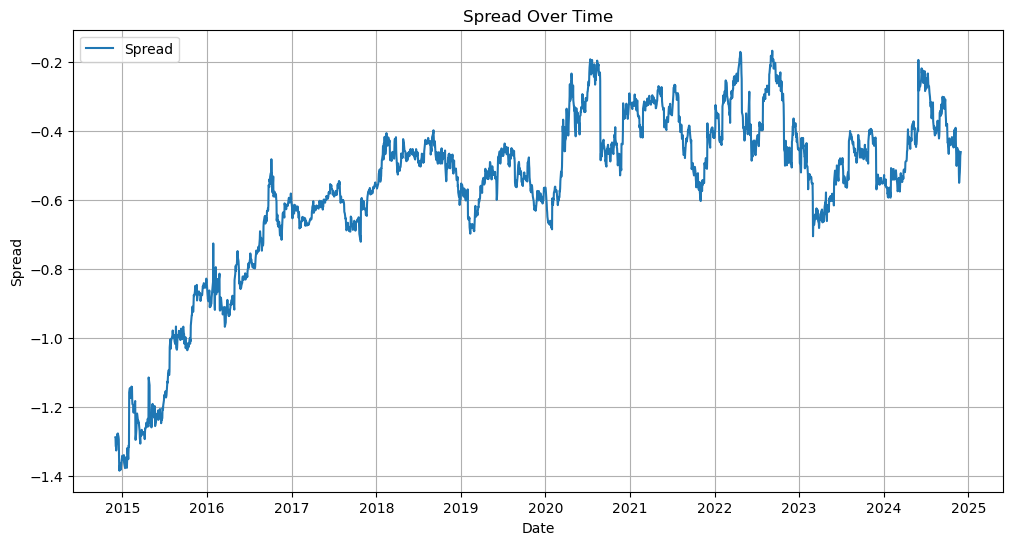


Best Pair: AMZN-CRM
Kappa: 0.005023191932141092
Half-Life: 137.98938800741803

Running Backtest Without Optimization...

Running Grid Search Optimization...

Best Parameters from Grid Search: {'entry_threshold': 1.0, 'lookback': 10, 'stoploss_factor': 2.5, 'initial_capital': 100000, 'capital_per_trade': 1000}

Running Backtest with Dynamic Stop-Loss and Leverage...


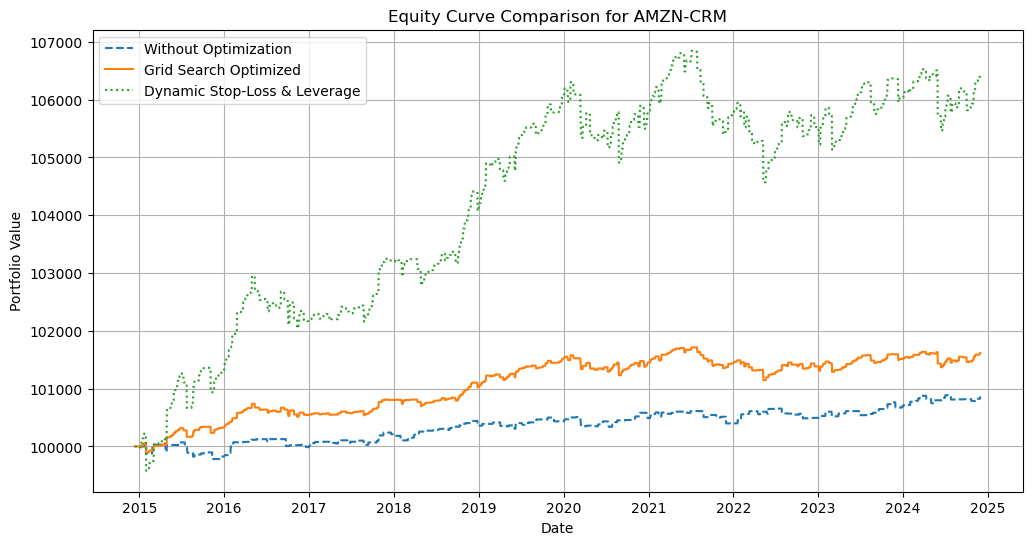


Comparison of Final Metrics:

Without Optimization:
Final Portfolio Value: 100865.30
Total Return (%): 0.87
Sharpe Ratio: 0.41

Grid Search Optimization:
Final Portfolio Value: 101616.56
Total Return (%): 1.62
Sharpe Ratio: 0.61

Dynamic Stop-Loss & Leverage:
Final Portfolio Value: 106447.17
Total Return (%): 6.45
Sharpe Ratio: 0.62


In [14]:
if __name__ == "__main__":
    # Load stock files and analyze pairs
    stock_directory = "tech"
    file_paths = load_stock_files_from_directory(stock_directory)
    stock_data = load_stock_data(file_paths)
    pair_results = analyze_all_pairs(stock_data)
    best_pair = select_best_pair(pair_results)
    stock1, stock2 = best_pair.split('-')

    # Calculate Kappa and Half-Life
    kappa, half_life = calculate_kappa_and_half_life(stock_data[stock1], stock_data[stock2])
    print(f"\nBest Pair: {best_pair}\nKappa: {kappa}\nHalf-Life: {half_life}")
    
    # Define base parameters
    base_params = {
        'lookback': 20,
        'entry_threshold': 1.5,
        'stoploss_factor': 2.0,
        'initial_capital': 100000,
        'capital_per_trade': 1000
    }
    param_grid = {
        'lookback': [10, 20, 30],
        'entry_threshold': [1.0, 1.5, 2.0],
        'stoploss_factor': [1.5, 2.0, 2.5]
    }

    # Backtest without optimization
    print("\nRunning Backtest Without Optimization...")
    base_metrics, base_equity_curve, _ = pair_trading_backtest(stock_data[stock1], stock_data[stock2], base_params, plot=False)

    # Perform Grid Search Optimization
    print("\nRunning Grid Search Optimization...")
    best_grid_params = grid_search_optimization(stock_data[stock1], stock_data[stock2], param_grid)
    grid_metrics, grid_equity_curve, _ = pair_trading_backtest(stock_data[stock1], stock_data[stock2], best_grid_params, plot=False)

    # Backtest with Dynamic Stop-Loss and Leverage
    print("\nRunning Backtest with Dynamic Stop-Loss and Leverage...")
    dynamic_metrics, dynamic_equity_curve, _ = pair_trading_backtest_dynamic_stoploss_leverage(
        stock_data[stock1], stock_data[stock2], best_grid_params, base_leverage=2, max_leverage=4, plot=False
    )

    # Plot all equity curves for comparison
    plt.figure(figsize=(12, 6))
    plt.plot(base_equity_curve, label="Without Optimization", linestyle='--')
    plt.plot(grid_equity_curve, label="Grid Search Optimized", linestyle='-')
    plt.plot(dynamic_equity_curve, label="Dynamic Stop-Loss & Leverage", linestyle=':')
    plt.title(f"Equity Curve Comparison for {best_pair}")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print Final Metrics for All Methods
    print("\nComparison of Final Metrics:")
    print("\nWithout Optimization:")
    for key, value in base_metrics.items():
        print(f"{key}: {value:.2f}")
    print("\nGrid Search Optimization:")
    for key, value in grid_metrics.items():
        print(f"{key}: {value:.2f}")
    print("\nDynamic Stop-Loss & Leverage:")
    for key, value in dynamic_metrics.items():
        print(f"{key}: {value:.2f}")
